## Acknowledgement

Utilized chatGPT 4o-canvas for assistance with selecting the best model type after initial r2 and MSE values were extremlely bad using linear regression. Here is the prompt I used: any suggestions for changes to improve the accuracy of the model?

Response Summary: Summary:
Your current model (linear regression) might be too simplistic to capture the complexities of fire smoke impact. Adding more features, trying non-linear models, and ensuring proper handling of data quality are crucial steps to improve accuracy. Specifically, Random Forest or Gradient Boosting are likely the next best options for capturing non-linear relationships and interactions between the variables.

From there, continued working through different prompts. But ultimately chose to go with chatGPT's suggestion of GradientBoost model, removing outliers, k-fold cross-validation, and bootstrapping

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.utils import resample

In [19]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

NORM_WT_FTRS_OUTPUT_PATH = output_paths.get('normalize_and_weight_features.csv')

MODEL_OUTPUT_PATH = output_paths.get("model_output")

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

## Data Processing

In [20]:
# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

Years with NaN values: [2021]


### Remove Outliers

In [21]:
print("Max of scaled_avg_daily_smoke_impact before filtering outliers:")
print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Remove outliers using Interquartile Range (IQR) method
Q1 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.25)
Q3 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')
combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 0.5 * IQR)) & 
                          (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 0.5 * IQR))]

print("Max of scaled_avg_daily_smoke_impact after filtering outliers:")
print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Check if there are enough samples left after filtering
if combined_df.shape[0] == 0:
    raise ValueError("No samples left after filtering for outliers and NaN values. Consider relaxing the filtering criteria.")

Max of scaled_avg_daily_smoke_impact before filtering outliers:
52.782934279853016
Q1: 16.74033345730031, Q3: 34.60592853216895, IQR: 17.865595074868644
Max of scaled_avg_daily_smoke_impact after filtering outliers:
41.381605819145946


### Normalize & Apply Weights

In [22]:
# Define weights for 'total_acres_burned' and 'distance'
acres_weight = 1
dist_weight = 1

max_total_acres_burned_for_normalization = combined_df['total_acres_burned'].max()

# Create a DataFrame
df = pd.DataFrame({
    "acres_weight": [acres_weight],
    "dist_weight": [dist_weight],
    "max_total_acres_burned": [max_total_acres_burned_for_normalization]
})

# Save the DataFrame to a CSV file
df.to_csv(NORM_WT_FTRS_OUTPUT_PATH, index=False)

# Normalize total acres burned and distance
combined_df['total_acres_burned_normalized'] = combined_df['total_acres_burned'] / max_total_acres_burned_for_normalization
combined_df['distance_normalized'] = combined_df['avg_dist_from_city'] / 650

# Print before applying weights
print("\nBefore applying weights:")
print(combined_df[['total_acres_burned_normalized', 'distance_normalized']].head())

combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned_normalized'] * acres_weight
combined_df['distance_weighted'] = combined_df['distance_normalized'] * dist_weight

# Print after applying weights
print("\nAfter applying weights:")
print(combined_df[['total_acres_burned_weighted', 'distance_weighted']].head())


Before applying weights:
   total_acres_burned_normalized  distance_normalized
0                       0.030576             0.687161
3                       0.075037             0.616994
4                       0.019671             0.603956
5                       0.016044             0.534834
7                       0.013818             0.588911

After applying weights:
   total_acres_burned_weighted  distance_weighted
0                     0.030576           0.687161
3                     0.075037           0.616994
4                     0.019671           0.603956
5                     0.016044           0.534834
7                     0.013818           0.588911


### Prepare Data for Model Training

In [23]:
# Prepare the features and target variable
features = combined_df[['total_acres_burned_weighted', 'distance_weighted']]
labels = combined_df['scaled_avg_daily_smoke_impact'].values

# Print a few rows of features to verify
print("\nFeatures used for training:")
print(features.head())


Features used for training:
   total_acres_burned_weighted  distance_weighted
0                     0.030576           0.687161
3                     0.075037           0.616994
4                     0.019671           0.603956
5                     0.016044           0.534834
7                     0.013818           0.588911


### Model Training

In [24]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

# Define Gradient Boosting Regressor
# model = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with Cross-Validation
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best estimator from Grid Search
# model = grid_search.best_estimator_

# Initialize variables to keep track of the best model and score
best_model = None
best_mse_score = float("inf")

# Bootstrapping with a fixed random seed for consistency
bootstrap_iterations = 100
bootstrap_mse_scores = []
bootstrap_r2_scores = []

random_state = 42

kf = KFold(n_splits=3, shuffle=True, random_state=random_state)

for i in range(bootstrap_iterations):
    # Resample the data to create new bootstrap samples
    X_resampled, y_resampled = resample(features, labels, random_state=random_state+i)
    
    # Convert to numpy arrays if they are DataFrames or Series
    if isinstance(X_resampled, pd.DataFrame):
        X_resampled = X_resampled.to_numpy()
    if isinstance(y_resampled, pd.Series):
        y_resampled = y_resampled.to_numpy()
    
    mse_scores = []
    r2_scores = []
    
    # Cross-validation with a fresh model for each fold
    for train_index, test_index in kf.split(X_resampled):
        X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
        y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
        
        # Create a new instance of the model
        model = GradientBoostingRegressor(random_state=42)

        # Perform Grid Search to get the best estimator
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)
        model = grid_search.best_estimator_
        
        # Calculate scores on the current fold's test data
        y_pred_fold = model.predict(X_test_fold)
        fold_mse = np.mean((y_test_fold - y_pred_fold) ** 2)
        mse_scores.append(fold_mse)
        r2_scores.append(model.score(X_test_fold, y_test_fold))
    
    # Store the mean MSE and R2 for this bootstrap iteration
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    bootstrap_mse_scores.append(mean_mse)
    bootstrap_r2_scores.append(mean_r2)
    
    # Update best model if the current one has the lowest mean MSE
    if mean_mse < best_mse_score:
        best_mse_score = mean_mse
        best_model = model

# Output results
print(f"\nBest Bootstrapped Cross-Validation Mean Squared Error (MSE): {best_mse_score}")
print(f"Bootstrapped Cross-Validation Average MSE across iterations: {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation Average R-squared (R2) across iterations: {np.mean(bootstrap_r2_scores)}")

# Save the best model to a file using pickle
with open(MODEL_OUTPUT_PATH, 'wb') as model_file:
    pickle.dump(best_model, model_file)


Best Bootstrapped Cross-Validation Mean Squared Error (MSE): 3.429058145183639
Bootstrapped Cross-Validation Average MSE across iterations: 28.204046075723134
Bootstrapped Cross-Validation Average R-squared (R2) across iterations: 0.6431794318007121


/Users/debbiesubocz/anaconda3/envs/512_proj/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


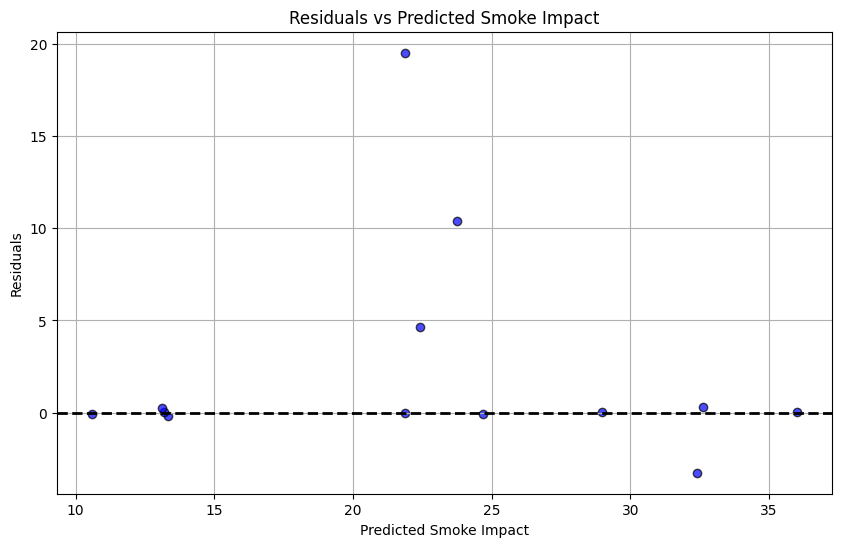

In [25]:
# Predict smoke estimates for the test set with the best model
y_pred = best_model.predict(X_test)

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Smoke Impact')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Smoke Impact')
plt.grid(True)
plt.show()

## MIGHT NEED TO CHANGE IT TO THIS INSTEAD

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from collections import Counter
import numpy as np
import pickle

# Set up fixed random state
fixed_random_state = 42

# Define the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=fixed_random_state)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

# Bootstrapping with Grid Search in each iteration
n_iterations = 100  # Number of bootstrap samples
boot_mse_scores = []
boot_r2_scores = []
boot_best_params = []  # To store best parameters from each iteration

# Variables to track the best model and its performance
best_overall_model = None
best_overall_r2 = -np.inf  # Initialize to negative infinity
best_overall_params = None

for i in range(n_iterations):
    # Resample with replacement to create a bootstrap sample
    X_resample, y_resample = resample(features, labels, replace=True, random_state=fixed_random_state + i)
    
    # Split the resampled dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=fixed_random_state)
    
    # Perform Grid Search on the bootstrap sample
    grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and hyperparameters
    best_gbr = grid_search.best_estimator_
    best_params = grid_search.best_params_
    boot_best_params.append(best_params)
    
    # Evaluate the best model on the test set
    y_pred = best_gbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the evaluation metrics
    boot_mse_scores.append(mse)
    boot_r2_scores.append(r2)
    
    # Update the best overall model if the current one is better
    if r2 > best_overall_r2:
        best_overall_r2 = r2
        best_overall_model = best_gbr
        best_overall_params = best_params

print("Best overall R^2 Score:", best_overall_r2)
print("Best overall hyperparameters:", best_overall_params)

# Summary Statistics
print("Average Bootstrap Mean Squared Error:", np.mean(boot_mse_scores))
print("Average Bootstrap R^2 Score:", np.mean(boot_r2_scores))

Best overall R^2 Score: 0.9999999999979233
Best overall hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Average Bootstrap Mean Squared Error: 29.070605806674553
Average Bootstrap R^2 Score: 0.620970628155796
Most Common Best Parameters Across Bootstraps: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 200}
Average Bootstrap Mean Squared Error (Fixed Params): 25.941468539987408
Average Bootstrap R^2 Score (Fixed Params): 0.6686355798010573


In [ ]:
# Analyze the best hyperparameters across bootstrap iterations
param_counts = Counter(tuple(p.items()) for p in boot_best_params)
most_common_params = param_counts.most_common(1)[0][0]
most_common_params = dict(most_common_params)  # Convert back to dictionary
print("Most Common Best Parameters Across Bootstraps:", most_common_params)

# Use the most common best parameters from the previous bootstrap
fixed_params = most_common_params
best_gbr_fixed = GradientBoostingRegressor(**fixed_params, random_state=fixed_random_state)

# Perform Bootstrapping Without Grid Search
boot_mse_scores_fixed = []
boot_r2_scores_fixed = []

for i in range(n_iterations):
    # Resample with replacement to create a bootstrap sample
    X_resample, y_resample = resample(features, labels, replace=True, random_state=fixed_random_state + i)
    
    # Split the resampled dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=fixed_random_state)
    
    # Train the model with fixed hyperparameters
    best_gbr_fixed.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = best_gbr_fixed.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the evaluation metrics
    boot_mse_scores_fixed.append(mse)
    boot_r2_scores_fixed.append(r2)

# Summary Statistics for Fixed Hyperparameters
print("Average Bootstrap Mean Squared Error (Fixed Params):", np.mean(boot_mse_scores_fixed))
print("Average Bootstrap R^2 Score (Fixed Params):", np.mean(boot_r2_scores_fixed))

In [ ]:
# Save the model to a file
with open('best_gbr_model.pkl', 'wb') as file:
    pickle.dump(best_gbr_fixed, file)

## Model Results

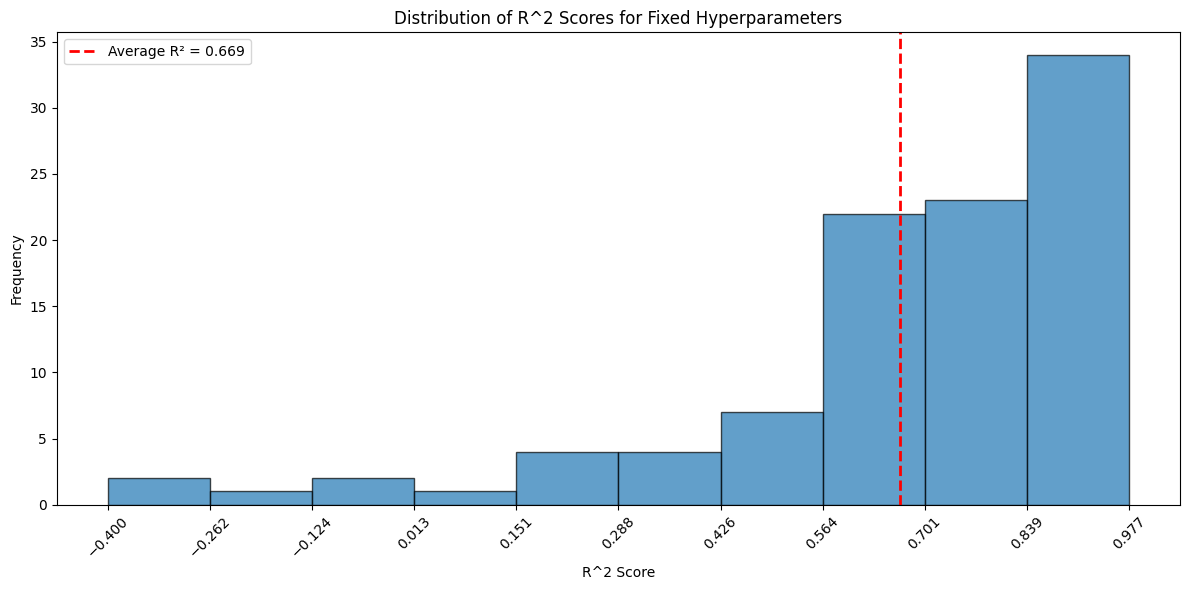

In [29]:
# Calculate the average R² score
average_r2 = np.mean(boot_r2_scores_fixed)

# Create histogram with 10 bins
bins = np.linspace(min(boot_r2_scores_fixed), max(boot_r2_scores_fixed), 11)  # 11 edges for 10 bins
hist, edges = np.histogram(boot_r2_scores_fixed, bins=bins)

# Plot histogram
plt.figure(figsize=(12, 6))  # Make the chart wider
plt.bar(edges[:-1], hist, width=np.diff(edges), align='edge', alpha=0.7, edgecolor='black')

# Add a vertical line for the average value
plt.axvline(average_r2, color='red', linestyle='--', linewidth=2, label=f'Average R² = {average_r2:.3f}')

# Set titles and labels
plt.title('Distribution of R^2 Scores for Fixed Hyperparameters')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')

# Set x-axis tick labels for each bin
plt.xticks(edges, rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



## Model Results after Removing Outliers

Number of Outliers Removed: 8
Average R² Score After Removing Outliers: 0.734


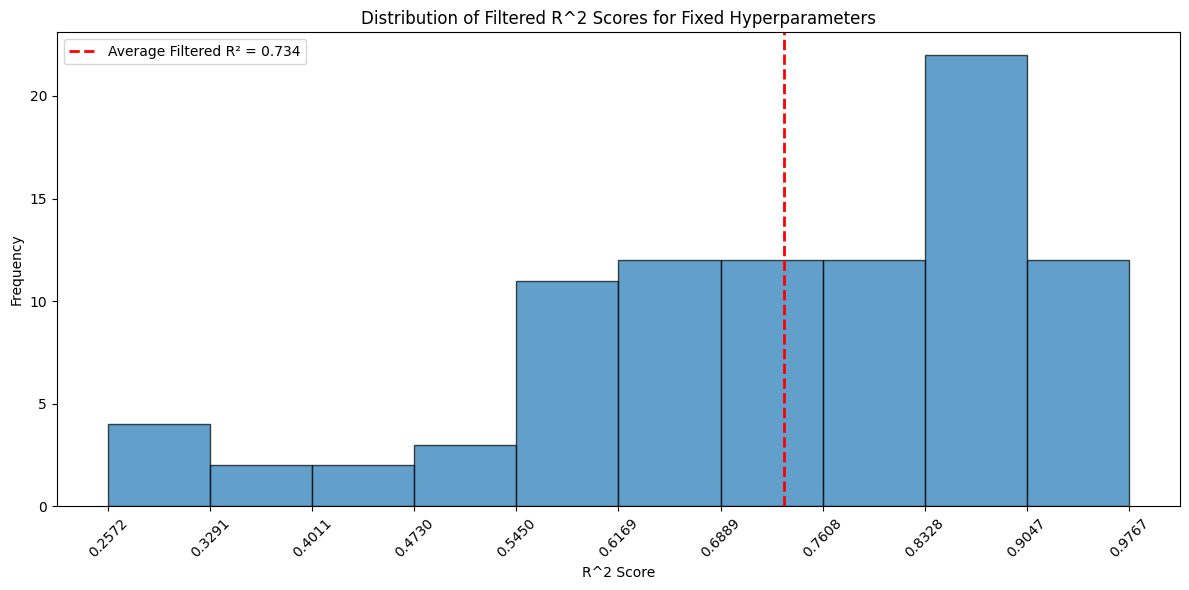

In [30]:
# Calculate the interquartile range (IQR) to identify and remove outliers
r2_scores = np.array(boot_r2_scores_fixed)
q1 = np.percentile(r2_scores, 25)  # 25th percentile
q3 = np.percentile(r2_scores, 75)  # 75th percentile
iqr = q3 - q1  # Interquartile range
lower_bound = q1 - 1.5 * iqr  # Define the lower bound for outlier removal
upper_bound = q3 + 1.5 * iqr  # Define the upper bound for outlier removal

# Filter the R² scores to remove outliers
filtered_r2_scores = r2_scores[(r2_scores >= lower_bound) & (r2_scores <= upper_bound)]

# Calculate the number of outliers removed
num_outliers = len(r2_scores) - len(filtered_r2_scores)
print(f"Number of Outliers Removed: {num_outliers}")

# Calculate the average R² score after removing outliers
average_filtered_r2 = np.mean(filtered_r2_scores)
print(f"Average R² Score After Removing Outliers: {average_filtered_r2:.3f}")

# Create histogram with 10 bins for the filtered R² scores
bins = np.linspace(min(filtered_r2_scores), max(filtered_r2_scores), 11)  # 11 edges for 10 bins
hist, edges = np.histogram(filtered_r2_scores, bins=bins)

# Plot histogram
plt.figure(figsize=(12, 6))  # Make the chart wider
plt.bar(edges[:-1], hist, width=np.diff(edges), align='edge', alpha=0.7, edgecolor='black')

# Add a vertical line for the average value of filtered R² scores
plt.axvline(average_filtered_r2, color='red', linestyle='--', linewidth=2, label=f'Average Filtered R² = {average_filtered_r2:.3f}')

# Set titles and labels
plt.title('Distribution of Filtered R^2 Scores for Fixed Hyperparameters')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')

# Set x-axis tick labels for each bin
plt.xticks(edges, rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
